In [1]:
import numpy as np
from pprint import pprint

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import log_loss, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

from scipy.stats import loguniform

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8, 6))

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

Binary classification with SGDRegressor on MNIST data

In [3]:
from sklearn.datasets import fetch_openml
X_pd, y_pd = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
X = X_pd.to_numpy()
y = y_pd.to_numpy()

We'll use a sigmoid function for the loss calculation here, so feature matrix should be scaled from 0 to 1.

In [5]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

print(f'Mean of the features: {np.mean(X)}')
print(f'Std.deviation: {np.std(X)}')
print(f'Minimum value: {np.min(X)}')
print(f'Maximum value: {np.max(X)}')

Mean of the features: 0.13092720382627604
Std.deviation: 0.3084510570135976
Minimum value: 0.0
Maximum value: 1.0


In [6]:
target_names = np.unique(y)
print(f'Number of samples: {X.shape[0]}, type: {X.dtype}')
print(f'NUmber of features: {X.shape[1]}')
print(f'Number of classes: {len(target_names)}, type: {y.dtype}')
print(f'Labels: {target_names}')

Number of samples: 70000, type: float64
NUmber of features: 784
Number of classes: 10, type: object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

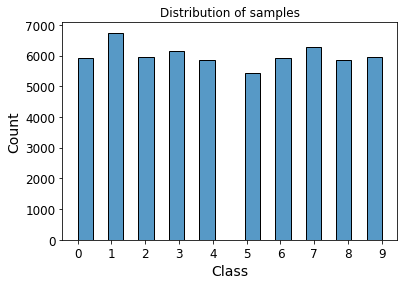

In [8]:
plt.figure()
sns.histplot(data=np.int8(y_train), binwidth=0.45, bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

In [9]:
#initialize new variable names with all 0
y_train_0 = np.zeros(y_train.shape[0])
y_test_0 = np.zeros(y_test.shape[0])

#find indices of digit 0 image
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

print(y_train)
print(y_train_0)

['5' '0' '4' ... '5' '6' '8']
[0. 1. 0. ... 0. 0. 0.]


# Dummy (Baseline) classifier

In [10]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == 0)[0])

base_clf = DummyClassifier(strategy='most_frequent')
base_clf.fit(X_train, y_train_0)
print(f'Training accuracy: {base_clf.score(X_train, y_train_0):.4f}')
print(f'Testing accuracy: {base_clf.score(X_test, y_test_0):.4f}')

Training accuracy: 0.9013
Testing accuracy: 0.9020


Reason is obvious.  The model would've predicted 54077 samples correctly just by output 0 for all nput samples, Therefore, the accuracy will be 54077/60000 = 90.12%

# SGDClassifier (log loss)

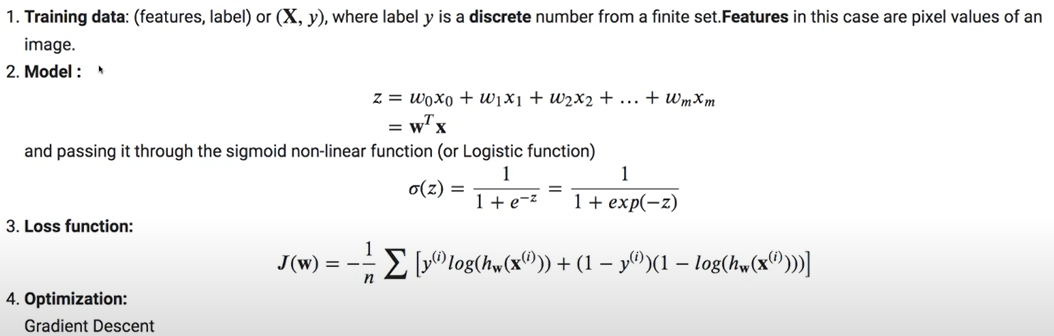

Training without Regularization

In [11]:
bin_sgd_clf = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, eta0=0.01, alpha=0, learning_rate='constant', random_state=1729)
Loss = []
iterations = 100
for i in range(iterations):
  bin_sgd_clf.fit(X_train, y_train_0)
  y_pred = bin_sgd_clf.predict_proba(X_train)
  Loss.append(log_loss(y_train_0, y_pred))

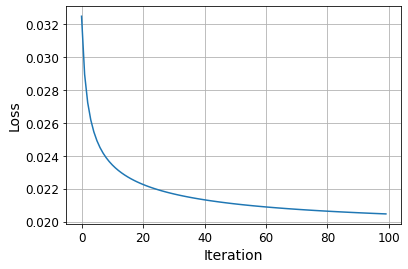

In [12]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

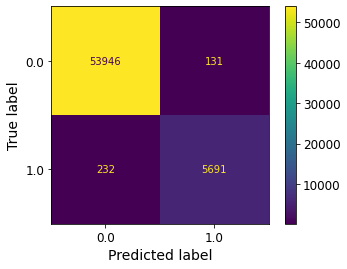

In [13]:
y_hat_train_0 = bin_sgd_clf.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='0.5g')

In [14]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0, 0]
fn = cf_matrix[1, 0]
fp = cf_matrix[0, 1]
tp = cf_matrix[1, 1]

precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tn + tp) / (tp + fp + tn + fn)
print(f"Precision: {precision}, Recall: {recall}, Acccuracy: {accuracy}")

Precision: 0.9774991411885949, Recall: 0.9608306601384433, Acccuracy: 0.99395


In [15]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54077
         1.0       0.98      0.96      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



Now, let's see how much generalization can be achieved by cross-validation

In [16]:
estimator = SGDClassifier(loss='log', penalty='l2', max_iter=100, warm_start=False, eta0=0.01, alpha=0, learning_rate='constant', random_state=1729)

cv_bin_clf = cross_validate(estimator, X_train, y_train_0, cv=5, scoring=['precision', 'recall', 'f1'], return_train_score=True, return_estimator=True)

pprint(cv_bin_clf)

{'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729)],
 'fit_time': array([1.46711659, 1.43725538, 1.41234994, 1.59124637, 1.29183555]),
 'score_time': array([0.04547668, 0.04187179, 0.04281998, 0.04165792, 0.04361939]),
 'test_f1': array([0.95699831, 0.954371  , 0.9616041 , 0.95870583, 0.95993252]),
 'test_precision': array([0.95538721, 0.96382429, 0.97238999, 0.96735395, 0.9

In [17]:
weights = bin_sgd_clf.coef_
bias = bin_sgd_clf.intercept_
weights.shape, bias

((1, 784), array([-4.89282893]))

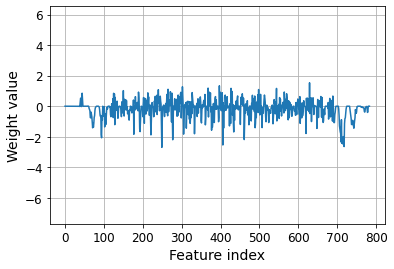

In [18]:
plt.figure()
plt.plot(np.arange(0, 784), weights[0, :])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim(np.min(weights) - 5, np.max(weights) + 5)
plt.grid()

Training with regularization

In [19]:
bin_sgd_clf_l2 = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, eta0=0.01, alpha=0.001, learning_rate='constant', random_state=1729)
Loss = []
iterations = 100
for i in range(iterations):
  bin_sgd_clf_l2.fit(X_train, y_train_0)
  y_pred = bin_sgd_clf_l2.predict_proba(X_train)
  Loss.append(log_loss(y_train_0, y_pred))

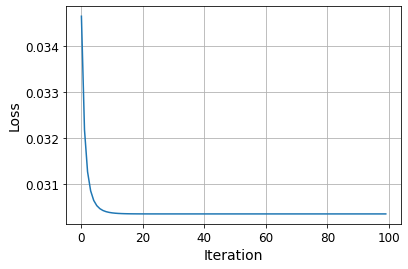

In [20]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

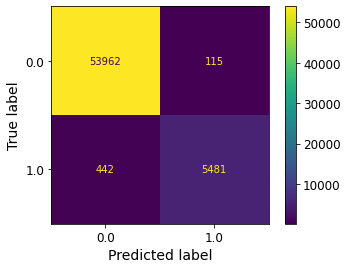

In [21]:
y_hat_train_0 = bin_sgd_clf_l2.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='0.5g')

In [22]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



In [23]:
weights = bin_sgd_clf_l2.coef_
bias = bin_sgd_clf_l2.intercept_
weights.shape, bias

((1, 784), array([-4.43002876]))

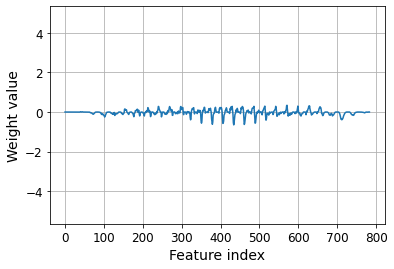

In [24]:
plt.figure()
plt.plot(np.arange(0, 784), weights[0, :])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim(np.min(weights) - 5, np.max(weights) + 5)
plt.grid()

Hyper-parameter tuning

In [25]:
from scipy.sparse.construct import random
lr_grid = loguniform(1e-2, 1e-1)
print(lr_grid.rvs(3, random_state=42))

[0.02368864 0.0892718  0.05395031]


In [26]:
estimator = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, eta0=0.01, alpha=0, learning_rate='constant', random_state=1729)

scores = RandomizedSearchCV(estimator, param_distributions={'eta0': lr_grid}, cv=5, scoring=['precision', 'recall', 'f1'], n_iter=5, refit='f1')

scores.fit(X_train, y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(alpha=0, eta0=0.01,
                                           learning_rate='constant', loss='log',
                                           max_iter=1, random_state=1729,
                                           warm_start=True),
                   n_iter=5,
                   param_distributions={'eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f23dffd7210>},
                   refit='f1', scoring=['precision', 'recall', 'f1'])

In [27]:
scores.cv_results_

{'mean_fit_time': array([0.330446  , 0.33043823, 0.32343721, 0.32490907, 0.32067051]),
 'mean_score_time': array([0.04571314, 0.04467335, 0.04336452, 0.04405203, 0.04214888]),
 'mean_test_f1': array([0.95383975, 0.94148246, 0.94869555, 0.95090017, 0.95474878]),
 'mean_test_precision': array([0.96136672, 0.93597638, 0.94998271, 0.9540212 , 0.96640269]),
 'mean_test_recall': array([0.94682062, 0.94851138, 0.94834146, 0.94850966, 0.94361173]),
 'param_eta0': masked_array(data=[0.02368863950364078, 0.08927180304353625,
                    0.05395030966670228, 0.039687933304443715,
                    0.01432249371823025],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'eta0': 0.02368863950364078},
  {'eta0': 0.08927180304353625},
  {'eta0': 0.05395030966670228},
  {'eta0': 0.039687933304443715},
  {'eta0': 0.01432249371823025}],
 'rank_test_f1': array([2, 5, 4, 3, 1], dtype=int32),
 'rank_test_precision': array([2, 5

In [28]:
scores.best_estimator_

SGDClassifier(alpha=0, eta0=0.01432249371823025, learning_rate='constant',
              loss='log', max_iter=1, random_state=1729, warm_start=True)

In [29]:
y_hat_train_best_0 = scores.best_estimator_.predict(X_train)

In [30]:
print(classification_report(y_train_0, y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.92      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



# Logistic Regression

Training without regularization

In [31]:
pipe_logit = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1729, solver='lbfgs', C=np.infty)) # C = np.infty means 0 regularization
pipe_logit.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

Hyper-parameter search

In [32]:
from sklearn.pipeline import Pipeline

grid_Cs = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]

scaler = MinMaxScaler()

logreg = LogisticRegression(C=1.0, random_state=1729) # initialized C with some value, and use grid_Cs for GridSearchCV

pipe = Pipeline(steps=[('scaler', scaler), ('logistic', logreg)])
pipe_logit_cv = GridSearchCV(pipe, param_grid={'logistic__C': grid_Cs}, scoring='f1')
pipe_logit_cv.fit(X_train, y_train_0)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logistic__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0]},
             scoring='f1')

In [33]:
pipe_logit_cv.best_params_

{'logistic__C': 0.1}

In [34]:
pipe_logit_cv.best_score_

0.9579654953103655

In [35]:
pipe_logit_cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=0.1, random_state=1729))])

# LogisticRegressionCV (instead of GridSearchCV)

In [36]:
estimator = LogisticRegressionCV(cv=5, scoring='f1', random_state=1729)
logit_cv = make_pipeline(MinMaxScaler(), estimator)
logit_cv.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(cv=5, random_state=1729, scoring='f1'))])

In [37]:
lr_y_hat_0 = pipe_logit.predict(X_test)
lr_gs_y_hat_0 = pipe_logit_cv.best_estimator_.predict(X_test)
lr_cv_y_hat_0 = logit_cv.predict(X_test)

In [38]:
precision_lr = precision_score(y_test_0, lr_y_hat_0)
recall_lr = recall_score(y_test_0, lr_y_hat_0)

precision_lr_gs = precision_score(y_test_0, lr_gs_y_hat_0)
recall_lr_gs = recall_score(y_test_0, lr_gs_y_hat_0)

precision_lr_cv = precision_score(y_test_0, lr_cv_y_hat_0)
recall_lr_cv = recall_score(y_test_0, lr_cv_y_hat_0)

In [39]:
print(f'LogReg: precision={precision_lr}, recall={recall_lr}')
print(f'GridSearch: precision={precision_lr_gs}, recall={recall_lr_gs}')
print(f'LogRegCV: precision={precision_lr_cv}, recall={recall_lr_cv}')

LogReg: precision=0.9515151515151515, recall=0.9612244897959183
GridSearch: precision=0.9564336372847011, recall=0.963265306122449
LogRegCV: precision=0.9546370967741935, recall=0.9663265306122449


LogisticRegression classifier obtained through GridSearchCV has the highest precision

In [40]:
y_scores_lr = pipe_logit.decision_function(X_test)
precision_lr, recalls_lr, threshold_lr = precision_recall_curve(y_test_0, y_scores_lr)

y_scores_lr_gs = pipe_logit_cv.decision_function(X_test)
precision_lr_gs, recalls_lr_gs, threshold_lr_gs = precision_recall_curve(y_test_0, y_scores_lr_gs)

y_scores_lr_cv = logit_cv.decision_function(X_test)
precision_lr_cv, recalls_lr_cv, threshold_lr_cv = precision_recall_curve(y_test_0, y_scores_lr_cv)

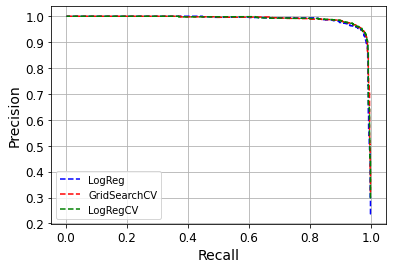

In [41]:
plt.figure()
plt.plot(recalls_lr[:-1], precision_lr[:-1], 'b--', label='LogReg')
plt.plot(recalls_lr_gs[:-1], precision_lr_gs[:-1], 'r--', label='GridSearchCV')
plt.plot(recalls_lr_cv[:-1], precision_lr_cv[:-1], 'g--', label='LogRegCV')

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(True)
plt.legend(loc='lower left')

Confusion Matrix

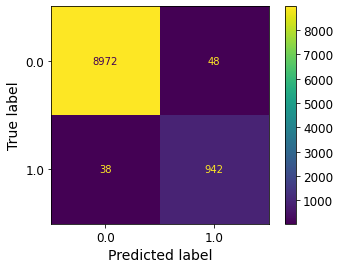

In [42]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_y_hat_0, values_format='0.5g') # From logistic regression

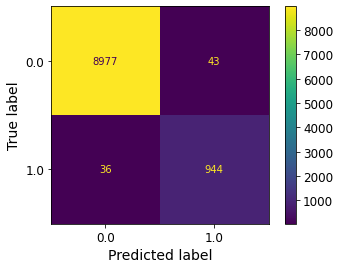

In [43]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_gs_y_hat_0, values_format='0.5g') # From GridSearchCV

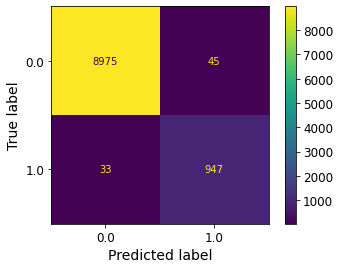

In [44]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_cv_y_hat_0, values_format='0.5g') # LogisticRegressionCV

# Ridge Classifier

In [45]:
#initialize new variable names with all 0
y_train_0 = -1 * np.ones(y_train.shape[0])
y_test_0 = -1 * np.ones(y_test.shape[0])

#find indices of digit 0 image
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

print(y_train)
print(y_train_0)

['5' '0' '4' ... '5' '6' '8']
[-1.  1. -1. ... -1. -1. -1.]


In [46]:
estimator = RidgeClassifier(normalize=False, alpha=0) # No regularization
pipe_ridge = make_pipeline(MinMaxScaler(), estimator)
pipe_ridge.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])

Performance

In [47]:
y_hat_test_0 = pipe_ridge.predict(X_test)
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99      9020
         1.0       0.95      0.87      0.91       980

    accuracy                           0.98     10000
   macro avg       0.97      0.93      0.95     10000
weighted avg       0.98      0.98      0.98     10000



Cross-validation

In [48]:
cv_bin_ridge_clf = cross_validate(pipe_ridge, X_train, y_train_0, cv=5, scoring=['precision', 'recall', 'f1'], return_train_score=True, return_estimator=True)
pprint(cv_bin_ridge_clf)

{'estimator': [Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])],
 'fit_time': array([13.36261964, 11.53238177, 11.5358994 , 11.57012796, 11.5862937 ]),
 'score_time': array([0.11302114, 0.11914968, 0.12636542, 0.14821792, 0.10943675]),
 'test_f1': array([0.90710859, 0.90917108, 0.92334802, 0.904     , 0.90892857]),
 'test_preci

In [51]:
best_estimator_id = np.argmax(cv_bin_ridge_clf['train_f1'])
print(best_estimator_id)

2


In [52]:
best_estimator = cv_bin_ridge_clf['estimator'][best_estimator_id]

In [54]:
y_hat_test_0 = best_estimator.predict(X_test)
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99      9020
         1.0       0.95      0.90      0.93       980

    accuracy                           0.99     10000
   macro avg       0.97      0.95      0.96     10000
weighted avg       0.99      0.99      0.99     10000



# Multiclass SGDClassifier (log loss)

In [55]:
estimator = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, eta0=0.01, alpha=0, learning_rate='constant', random_state=1729)
pipe_sgd_ovr = make_pipeline(MinMaxScaler(), estimator)

In [56]:
Loss = []
iterations = 100
for i in range(iterations):
  pipe_sgd_ovr.fit(X_train, y_train)  # train on all classes
  y_pred = pipe_sgd_ovr.predict_proba(X_train)
  Loss.append(log_loss(y_train, y_pred))

Text(0, 0.5, 'Loss')

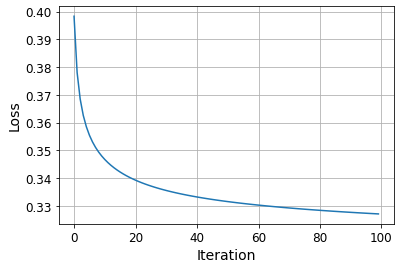

In [57]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [58]:
y_hat = pipe_sgd_ovr.predict(X_test)

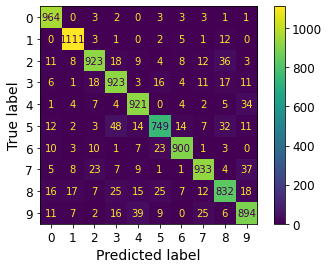

In [60]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='0.5g')

In order to manually calculate the precision and recall, follow this procedure on the above ConfusionMatrix.

- True positive: diagonal position, cm(x, x).
- False positive: sum of column x (without main diagonal), sum(cm(:, x))-cm(x, x).
- False negative: sum of row x (without main diagonal), sum(cm(x, :), 2)-cm(x, x).

Note that the same report can be automatically obtained through the function classification_report

In [61]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.88      0.91      0.90      1010
           4       0.91      0.94      0.92       982
           5       0.90      0.84      0.87       892
           6       0.95      0.94      0.95       958
           7       0.93      0.91      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.92      0.91     10000



# Multiclass LogisticRegression (solvers)

In [62]:
pipe_logit_ovr = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1729, solver='lbfgs', C=np.infty))  # C=np.infty indicates no regularization
pipe_logit_ovr.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

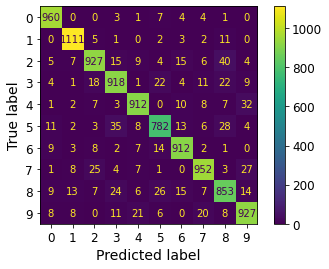

In [64]:
y_hat = pipe_logit_ovr.predict(X_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='0.5g')

In [65]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000

